<a href="https://colab.research.google.com/github/jiuyuanx/Application-of-NLP-and-LLM/blob/main/A3-HateSpeech-Classification-BertEmbeddings/HateSpeech_Bert_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas==1.5.0


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
!pip install -q torchsummaryX
import matplotlib.pyplot as plt
pd.__version__

'1.5.0'

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## **Load Hate Speech Dataset**

In [ ]:
df = pd.read_pickle("https://github.com/jiuyuanx/94812-Application-of-NLP-and-LLM/blob/main/A3-HateSpeech-Classification-BertEmbeddings/clean_df.pkl?raw=true")
df

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...
3,3,0,3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit you hear about me might be true or...
...,...,...,...,...,...,...
25291,3,0,3,0,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,yous a muthafin lie right his tl is trash ...
25292,3,0,3,0,"you've gone and broke the wrong heart baby, an...",youve gone and broke the wrong hea baby and dr...
25294,3,0,3,0,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like i aint fu...
25295,6,0,6,0,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies


In [ ]:
# assigning variables to essential columns
data = df['clean_tweets']
label = df['label']

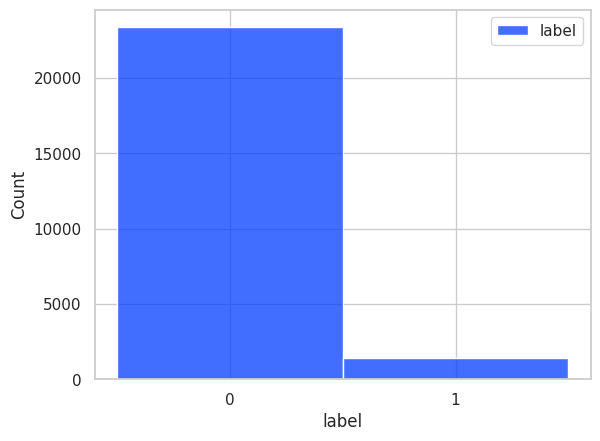

In [ ]:
sns.set(style = 'whitegrid', palette='bright')
sns.histplot(pd.DataFrame(label)['label'].apply(lambda x:str(x)), label='label')
plt.legend()

## **Cleaning, Tokenize and Lemmatize**

### **Clean witn NLTK**

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def process_tweet(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

processed_data = list(map(process_tweet, data))
len(processed_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


24783

In [ ]:
from nltk.probability import FreqDist
all_tokens = [item for sublist in processed_data for item in sublist]
clean_corpus_freqdist = FreqDist(all_tokens)
# top 20 words in cleaned corpus
clean_corpus_freqdist.most_common(20)

[('bitch', 8227),
 ('bitches', 3083),
 ('like', 2766),
 ('hoes', 2368),
 ('pussy', 2099),
 ('im', 2061),
 ('hoe', 1906),
 ('dont', 1749),
 ('got', 1597),
 ('ass', 1570),
 ('get', 1428),
 ('fuck', 1411),
 ('u', 1280),
 ('shit', 1262),
 ('nigga', 1198),
 ('aint', 1158),
 ('trash', 1142),
 ('lol', 1074),
 ('know', 806),
 ('niggas', 791)]

### **Lemmatization**

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer

lemmatizer = WordNetLemmatizer()
lemmatized_data = []

for text in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(word) for word in text])
    lemmatized_data.append(lemmed)
len(lemmatized_data)

[nltk_data] Downloading package wordnet to /root/nltk_data...


24783

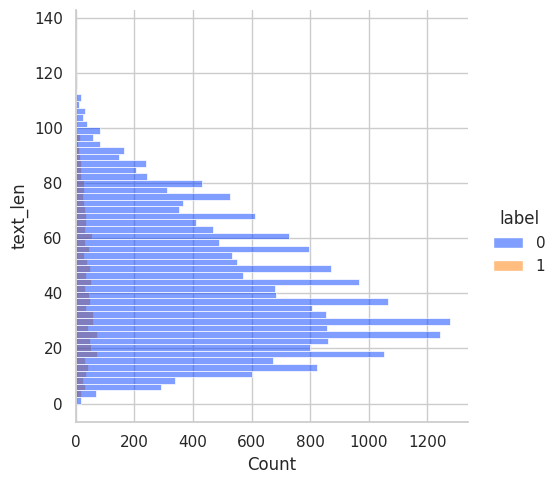

In [ ]:
stats = pd.DataFrame({'text':lemmatized_data, 'label':label})
stats['text_len'] = stats['text'].apply(lambda x:len(x))
sns.displot(stats, y='text_len', hue='label')

**We can see the hatespeech has very low percentage in the dataset, so we'll have to do upsampling.
Also majority text has a length under 60. So we'll perform padding and truncation to unsure they all have a length 60, for tensor training by deep learning models.**

## **Bert Tokenizer, Truncate, Pad for Array**

In [ ]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

model_name = 'Hate-speech-CNERG/bert-base-uncased-hatexplain'
tokenizer = BertTokenizer.from_pretrained(model_name)
# bert = BertModel.from_pretrained(model_name).to(device)
bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)
# 0: Hate Speech
# 1: Offensive Language
# 2: Normal Speech

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=60,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )

  return out

In [ ]:
# X_tokenized = [list(tokenize(x).values()) for x in lemmatized_data ]
X_tokenized = [tokenize(x) for x in lemmatized_data ]
print("shape of one news:", X_tokenized[0]['input_ids'].shape)
lemmatized_data[0], label[0], X_tokenized[0]

shape of one news: torch.Size([1, 60])


('woman shouldnt complain cleaning house man always take trash',
 0,
 {'input_ids': tensor([[  101,  2450,  5807,  2102, 17612,  9344,  2160,  2158,  2467,  2202,
          11669,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0

In [ ]:
att_mask = [x['attention_mask'] for  x in X_tokenized]
len(att_mask), att_mask[0]

(24783,
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

**Bert Inferencing**

In [ ]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return (self.input_ids[index].to(device), self.token_type_ids[index].to(device), self.att_mask[index].to(device))
inference_data = NLPDataset(X_tokenized)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 328,
    shuffle=False
)
len(inference_data), len(inference_loader)

(24783, 76)

**Final Classification:**

In [ ]:
predictions = []
for tokens in tqdm(inference_loader, "Bert inferencing..."):
  input_ids, token_type_ids, attention_mask = tokens
  with torch.no_grad():
      outputs = bert(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask= attention_mask)
      predictions.extend(list(outputs.logits.argmax(-1).squeeze().cpu().numpy()))

      # assert(False)
      # predictions.append(outputs.squeeze().cpu())
predictions

In [ ]:
np.unique(np.array(predictions), return_counts=True)

(array([0, 1, 2]), array([ 1042,  6976, 16765]))

In [ ]:
from sklearn.metrics import classification_report
#offensive as hate, low precision, higher recall
y_pred = [0 if i == 2 else 1 for i in predictions]
report_test = classification_report(df['label'], y_pred)
print(report_test )

              precision    recall  f1-score   support

           0       0.95      0.68      0.79     23353
           1       0.08      0.43      0.13      1430

    accuracy                           0.67     24783
   macro avg       0.51      0.55      0.46     24783
weighted avg       0.90      0.67      0.76     24783



In [ ]:
#offensive as non hate, less recall, more precision
y_pred = [0 if i == 2 or i==1 else 1 for i in predictions]
report_test = classification_report(df['label'], y_pred)
print(report_test )

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     23353
           1       0.34      0.25      0.28      1430

    accuracy                           0.93     24783
   macro avg       0.65      0.61      0.62     24783
weighted avg       0.92      0.93      0.92     24783



**bert embeddings**

In [ ]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

model_name = 'Hate-speech-CNERG/bert-base-uncased-hatexplain'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert = BertModel.from_pretrained(model_name).to(device)
# bert = BertForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)
# 0: Hate Speech
# 1: Offensive Language
# 2: Normal Speech

In [ ]:
#embeddings last_hidden_state/pooler_output
embeddings = []
for tokens in tqdm(inference_loader, "Bert inferencing..."):
  input_ids, token_type_ids, attention_mask = tokens
  with torch.no_grad():
      outputs = bert(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask= attention_mask)
      # embeddings.append(outputs.pooler_output.squeeze().cpu())
      embeddings.append(outputs.last_hidden_state.squeeze().cpu())
embeddings[0].shape

Bert inferencing...:   0%|          | 0/76 [00:00<?, ?it/s]

torch.Size([328, 60, 768])

## **Pytorch**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import gc

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


## **Dataset & Dataloader**

In [ ]:
config = {
    'batch_size': 64, # Increase this if your GPU can handle it
    'lr': 1e-3,
    'bert_lr':1e-6,
    'epochs': 10,
}

In [ ]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data, label) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        self.label = torch.LongTensor(np.array(label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return (self.input_ids[index].to(device),
                self.token_type_ids[index].to(device),
                self.att_mask[index].to(device)), self.label[index]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tokenized, df['label'], test_size=0.25, random_state=42)
print("Label count:", np.unique(y_train, return_counts=True))
np.array(X_train).shape, y_train.shape

Label count: (array([0, 1]), array([17518,  1069]))


((18587, 3), (18587,))

Label count: (array([0, 1]), array([17518, 17518]))


(35036, (35036,))

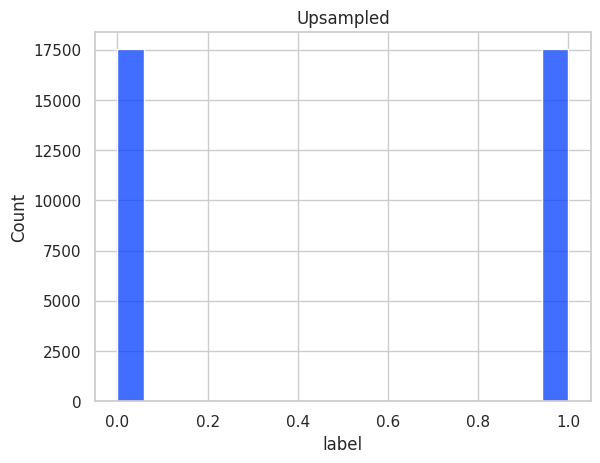

In [ ]:
sm = SMOTE(random_state=42)
indices_resampled, y_train = sm.fit_resample(np.arange(len(X_train))[:, np.newaxis], y_train)
X_train = [X_train[i] for i in indices_resampled.squeeze()]
print("Label count:", np.unique(y_train, return_counts=True))
sns.histplot(y_train)
plt.title("Upsampled")
len(X_train), y_train.shape

In [ ]:
train_data = NLPDataset(X_train, y_train)
val_data = NLPDataset(X_test, y_test)
len(train_data), len(val_data)

(35036, 6196)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config['batch_size']//2,
    shuffle=False
)

for batch in train_loader:
    X, y=batch
    print("Sample batch shape:", X[0].shape, y.shape, y)
    break

Sample batch shape: torch.Size([64, 60]) torch.Size([64]) tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])


## **Fine tune Bert**

In [ ]:
class BERT(nn.Module):
    def __init__(self, bert, output_class = 2):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,output_class)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)

In [ ]:
bert = BertModel.from_pretrained(model_name).to(device)
model=BERT(bert, 2).to(device)
# print(x.size)
for X, y in train_loader:
    print("x shape:", [x.shape for x in X], "y shape:", y.shape)
    out = model(X)
    print("out shape:", out.shape)
    summary(model, X)
    break

x shape: [torch.Size([64, 60]), torch.Size([64, 60]), torch.Size([64, 60])] y shape: torch.Size([64])
out shape: torch.Size([64, 2])
                                                    Kernel Shape  \
Layer                                                              
0_bert.embeddings.Embedding_word_embeddings         [768, 30522]   
1_bert.embeddings.Embedding_token_type_embeddings       [768, 2]   
2_bert.embeddings.Embedding_position_embeddings       [768, 512]   
3_bert.embeddings.LayerNorm_LayerNorm                      [768]   
4_bert.embeddings.Dropout_dropout                              -   
5_bert.encoder.layer.0.attention.self.Linear_query    [768, 768]   
6_bert.encoder.layer.0.attention.self.Linear_key      [768, 768]   
7_bert.encoder.layer.0.attention.self.Linear_value    [768, 768]   
8_bert.encoder.layer.0.attention.self.Dropout_d...             -   
9_bert.encoder.layer.0.attention.output.Linear_...    [768, 768]   
10_bert.encoder.layer.0.attention.output.Dropou... 

In [ ]:
#fine tuning learning rate group
bert_parameters = [param for name, param in model.named_parameters() if 'bert' in name]
classification_parameters = [param for name, param in model.named_parameters() if 'mlp' in name]
param_groups = [
    {'params': classification_parameters, 'lr': config['lr']},
    {'params': bert_parameters, 'lr': config['bert_lr']}
]

In [ ]:
optimizer   = torch.optim.AdamW(param_groups, weight_decay = 1e-2)
criterion   = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)
print("loss:", criterion(out, y.to(device)))

loss: tensor(0.6947, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
def train():
      model.train() # set to training mode
      model.to(device)
      train_plot=[]

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      total_loss        = 0.0
      num_correct = 0
      predictions = []
      true_labels = []

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()
          X, y = batch
          X = X
          y = y.to(device)
          y_pred = model(X)

          loss = criterion(y_pred, y)
          loss.backward()

          # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()

          train_plot.append(loss.item())
          total_loss += loss.item()
          num_correct     += int((torch.argmax(y_pred, axis=1) == y).sum())

          predictions.append(y_pred.argmax(1).int().cpu().detach().numpy())
          true_labels.append(y.cpu().detach().numpy())

          batch_bar.set_postfix(
              acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
              loss="{:.04f}".format(total_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              num_correct = num_correct,
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()


          del X,y
          gc.collect()
          torch.cuda.empty_cache()

      batch_bar.close()
      acc         = 100 * num_correct / (config['batch_size']* len(train_loader))
      total_loss  = float(total_loss / len(train_loader))

      return acc, total_loss, np.concatenate(predictions), np.concatenate(true_labels)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      total_loss        = 0.0
      num_correct = 0
      predictions = []
      true_labels = []

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          X, y = batch

          X = X
          y = y.to(device)
          y_pred = model(X)

          val_loss = criterion(y_pred, y)
          predictions.append(y_pred.argmax(1).int().cpu().detach().numpy())
          true_labels.append(y.cpu().detach().numpy())

          total_loss += val_loss.item()
          num_correct     += int((torch.argmax(y_pred, axis=1) == y).sum())

          batch_bar.set_postfix(
              acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
              loss="{:.04f}".format(total_loss/(i+1)),
              num_correct = num_correct
               )
          batch_bar.update()

          del X,y
          gc.collect()
          torch.cuda.empty_cache()

      batch_bar.close()
      acc         = 100 * num_correct / (config['batch_size']* len(val_loader))
      total_loss  = float(total_loss / len(val_loader))

      return acc, total_loss, np.concatenate(predictions), np.concatenate(true_labels)



## **Train Loop**

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# optimizer.param_groups[0]['lr']=1e-3
train_acc_plot=[]
train_loss_plot=[]
val_acc_plot=[]
val_loss_plot=[]
train_precision_plot=[]
train_recall_plot=[]
val_precision_plot=[]
val_recall_plot=[]
num_epochs=10
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss, train_predictions, train_true_labels            = train()
    train_precision_plot.append(precision_score(train_predictions, train_true_labels))
    train_recall_plot.append(recall_score(train_predictions, train_true_labels))


    train_loss_plot.append(train_loss)
    train_acc_plot.append(train_acc)
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Precision {:.04f}\t Recall {:.04f}\t Learning Rate {:.08f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        precision_score(train_predictions, train_true_labels),
        recall_score(train_predictions, train_true_labels),
        curr_lr))

    val_acc, val_loss, val_predictions, val_true_labels                = validate()
    val_precision_plot.append(precision_score(val_predictions, val_true_labels))
    val_recall_plot.append(recall_score(val_predictions, val_true_labels))

    val_loss_plot.append(val_loss)
    val_acc_plot.append(val_acc)
    scheduler.step()
    print("Val Acc {:.04f}%\t Val Loss {:.04f}\t Precision {:.04f}\t Recall {:.04f}".format(val_acc, val_loss,\
                                                       precision_score(val_predictions, val_true_labels),\
                                                       recall_score(val_predictions, val_true_labels)))



Epoch: 1/10


Train:   0%|          | 0/548 [00:00<?, ?it/s]


Epoch 1/10: 
Train Acc 53.7494%	 Train Loss 0.6856	 Precision 0.3019	 Recall 0.5721	 Learning Rate 0.00100000


Train:   0%|          | 0/194 [00:00<?, ?it/s]

Val Acc 43.5648%	 Val Loss 0.6626	 Precision 0.6343	 Recall 0.2590

Epoch: 2/10


Train:   0%|          | 0/548 [00:00<?, ?it/s]


Epoch 2/10: 
Train Acc 54.9356%	 Train Loss 0.6818	 Precision 0.1961	 Recall 0.6707	 Learning Rate 0.00085000


Train:   0%|          | 0/194 [00:00<?, ?it/s]

Val Acc 44.6843%	 Val Loss 0.6823	 Precision 0.6343	 Recall 0.3074

Epoch: 3/10


Train:   0%|          | 0/548 [00:00<?, ?it/s]


Epoch 3/10: 
Train Acc 55.4288%	 Train Loss 0.6796	 Precision 0.2086	 Recall 0.6784	 Learning Rate 0.00072250


Train:   0%|          | 0/194 [00:00<?, ?it/s]

Val Acc 43.2506%	 Val Loss 0.6783	 Precision 0.7064	 Recall 0.2615

Epoch: 4/10


Train:   0%|          | 0/548 [00:00<?, ?it/s]


Epoch 4/10: 
Train Acc 55.6541%	 Train Loss 0.6779	 Precision 0.1965	 Recall 0.7048	 Learning Rate 0.00061412


Train:   0%|          | 0/194 [00:00<?, ?it/s]

Val Acc 45.1192%	 Val Loss 0.6719	 Precision 0.6399	 Recall 0.3324

Epoch: 5/10


Train:   0%|          | 0/548 [00:00<?, ?it/s]


Epoch 5/10: 
Train Acc 55.7539%	 Train Loss 0.6774	 Precision 0.2085	 Recall 0.6932	 Learning Rate 0.00052201


Train:   0%|          | 0/194 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# Training Plot
ax1 = ax[0]
ax1.plot(train_loss_plot, label='Loss', color='blue')
ax1.set_ylabel("CrossEntropy Loss", color='blue')
ax1.set_xlabel("Epoch")
ax1.set_title("Training plot")
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the accuracy
ax2 = ax1.twinx()
ax2.plot(train_acc_plot, label='Accuracy', color='green')
ax2.set_ylabel("Accuracy", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Validation Plot
ax3 = ax[1]
ax3.plot(val_loss_plot, label='Loss', color='blue')
ax3.set_ylabel("CrossEntropy Loss", color='blue')
ax3.set_xlabel("Epoch")
ax3.set_title("Validation plot")
ax3.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the accuracy
ax4 = ax3.twinx()
ax4.plot(val_acc_plot, label='Accuracy', color='green')
ax4.set_ylabel("Accuracy", color='green')
ax4.tick_params(axis='y', labelcolor='green')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# Training Plot
ax1 = ax[0]
ax1.plot(train_precision_plot, label='Precision', color='blue')
ax1.plot(train_recall_plot, label='Recall', color='green')
ax1.set_ylabel("Precision", color='blue')
ax1.set_xlabel("Epoch")
ax1.set_title("Training plot")
ax1.tick_params(axis='y', labelcolor='blue')


# Validation Plot
ax3 = ax[1]
ax3.plot(val_precision_plot, label='Precision', color='blue')
ax3.plot(val_recall_plot, label='Recall', color='green')
ax3.set_ylabel("Precision", color='blue')
ax3.set_xlabel("Epoch")
ax3.set_title("Validation plot")
ax3.tick_params(axis='y', labelcolor='blue')

plt.legend()

plt.show()

In [ ]:
np.unique(y_test, return_counts=True)

## **Ensemble Decision Trees using embeddings**

**Because Hate Speech consists only 5% of our dataset. Predicting all data as non-hate can give you a accuracy 95%, but we fail to detect hateful speech. Therefore, we have to balance precision and recall. The model at the beginning has a high precision around 90% percent by predicting almost all data to be 0(non-hate), and the recall is around 5%(fail to detect hate). By training the model, accuracy is getting lower then rise and we are getting a lower precision higher accuracy and recall**

**Training: Precision 0.7074	 Recall 0.7372\
Validation: Precision 0.5623	 Recall 0.1306**

The recall does not increase a lot says that our model does not increase its ability in detecting hate speech very much.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train = np.array([np.array(x) for x in X_train])[:,0]
X_test = np.array([np.array(x) for x in X_test])[:,0]

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.9238218205293738
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5835
           1       0.38      0.47      0.42       361

    accuracy                           0.92      6196
   macro avg       0.67      0.71      0.69      6196
weighted avg       0.93      0.92      0.93      6196



In [ ]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(
    max_depth=3,  # Maximum depth of each tree
    learning_rate=0.1,  # Learning rate (adjust as needed)
    n_estimators=100  # Number of boosting rounds (trees)
)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.8058424790187217
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      5835
           1       0.20      0.76      0.31       361

    accuracy                           0.81      6196
   macro avg       0.59      0.78      0.60      6196
weighted avg       0.94      0.81      0.85      6196



### **The results of Random Forest(0.38, 0.47) XGBoost(0.2, 0.76) for (precision, recall) suggests that tree-based models on our task has a lower precision and a higher recall that Neural Network I trained. Tree-based models with Bert embeddings pretrained have a ourstanding ability to detect hateful speech  suggests that bert embeddings is powerful on downtream tasks.**